In [1]:
import jax.numpy as jnp


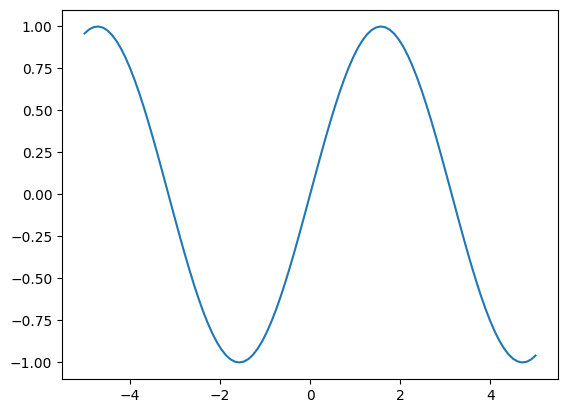

In [3]:
import matplotlib.pyplot as plt

x_jnp = jnp.linspace(-5, 5, 100)
y_jnp = jnp.sin(x_jnp)
plt.plot(x_jnp, y_jnp)

In [4]:
%xmode minimal

Exception reporting mode: Minimal


In [5]:
x = jnp.arange(10)
x[0] = 10


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [6]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


Jax Arrays

In [8]:
import jax

isinstance(x, jax.Array)

True

In [9]:
x.devices()

{CudaDevice(id=0)}

In [10]:
x.sharding

SingleDeviceSharding(device=CudaDevice(id=0), memory_kind=device)

Just-in-time compilation with jax.jit
Key concepts:

- By default JAX executes operations one at a time, in sequence.

- Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once.

- Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.

JAX runs transparently on the GPU or TPU (falling back to CPU if you don’t have one), with all JAX operations being expressed in terms of XLA. If we have a sequence of operations, we can use the jax.jit function to compile this sequence of operations together using the XLA compiler.

For example, consider this function that normalizes the rows of a 2D matrix, expressed in terms of jax.numpy operations:

In [11]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

In [12]:
from jax import jit
norm_compiled = jit(norm)

In [14]:
import numpy as np

np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

In [15]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

97.6 μs ± 2.24 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
44.8 μs ± 1.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


JIT requires all arrays to have static shapes. 

In [16]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

Array([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

In [17]:
jit(get_negatives)(x)


NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[10]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

Taking derivatives with jax.grad
Key concepts:

- JAX provides automatic differentiation via the jax.grad transformation.

- The jax.grad and jax.jit transformations compose and can be mixed arbitrarily.

In addition to transforming functions via JIT compilation, JAX also provides other transformations. One such transformation is jax.grad, which performs automatic differentiation (autodiff):

In [18]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661194 0.10499357]


In [19]:
def first_finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


In [20]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


In [21]:
from jax import jacobian
print(jacobian(jnp.exp)(x_small))

[[1.        0.        0.       ]
 [0.        2.7182817 0.       ]
 [0.        0.        7.389056 ]]


In [22]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))
print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085774 -0.        ]
 [-0.         -0.         -0.07996248]]


# Auto-vectorization with jax.vmap
Key concepts:

- JAX provides automatic vectorization via the jax.vmap transformation.

- jax.vmap can be composed with jax.jit to produce efficient vectorized code.

Another useful transformation is jax.vmap, the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of explicitly looping over function calls, it transforms the function into a natively vectorized version for better performance. When composed with jax.jit, it can be just as performant as manually rewriting your function to operate over an extra batch dimension.

We’re going to work with a simple example, and promote matrix-vector products into matrix-matrix products using jax.vmap. Although this is easy to do by hand in this specific case, the same technique can apply to more complicated functions.

In [28]:
from jax import random

key = random.key(1701)
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)

print(key)
print(key1)
print(key2)

Array((), dtype=key<fry>) overlaying:
[   0 1701]
Array((), dtype=key<fry>) overlaying:
[ 741045208 1847055613]
Array((), dtype=key<fry>) overlaying:
[  85238482 2594297577]


In [29]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
422 μs ± 10 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

AssertionError: 
Not equal to tolerance rtol=0.0001, atol=0.0001

Mismatched elements: 1149 / 1500 (76.6%)
Max absolute difference among violations: 0.01216316
Max relative difference among violations: 0.21894898
 ACTUAL: array([[-12.314034, -11.859842,  18.329819, ...,  -3.898189,   2.652005,
          6.3762  ],
       [ -0.743289,   3.605221,  -5.853775, ...,  -7.183311, -23.047962,...
 DESIRED: array([[-12.309202, -11.856992,  18.3293  , ...,  -3.900158,   2.653674,
          6.381835],
       [ -0.742689,   3.608296,  -5.85545 , ...,  -7.183761, -23.048897,...

In [36]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

AssertionError: 
Not equal to tolerance rtol=0.0001, atol=0.0001

Mismatched elements: 1149 / 1500 (76.6%)
Max absolute difference among violations: 0.01216316
Max relative difference among violations: 0.21894898
 ACTUAL: array([[-12.314034, -11.859842,  18.329819, ...,  -3.898189,   2.652005,
          6.3762  ],
       [ -0.743289,   3.605221,  -5.853775, ...,  -7.183311, -23.047962,...
 DESIRED: array([[-12.309202, -11.856992,  18.3293  , ...,  -3.900158,   2.653674,
          6.381835],
       [ -0.742689,   3.608296,  -5.85545 , ...,  -7.183761, -23.048897,...